In [1]:
import typing 
import pandas 
import seaborn
import cltrier_lib

SEED: int = 1
METRICS: typing.List[str] = ["public_metrics.impression_count", "public_metrics.like_count", "public_metrics.retweet_count", "public_metrics.reply_count"]

In [2]:
posts: pandas.DataFrame = (
    pandas.read_csv("../data/raw/twitter.german/GermanyMdBTweets_2023.csv", index_col=0)
    # exclude retweets
    .pipe(lambda _df: _df[~_df["text"].str.contains("RT")])
    # exclude tweets that start with a mention
    .pipe(lambda _df: _df[~_df["text"].str.startswith("@")])
    # exclude tweets with urls
    .pipe(lambda _df: _df[~_df["text"].str.contains("https://")])
    # exclude tweets that are short than 32 characters
    .pipe(lambda _df: _df[_df["text"].str.len() > 32])
)
posts

,id,author_id,conversation_id,text,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.impression_count,public_metrics.bookmark_count,created_at,username
2,1625441437167849472,1001837201276235777,1625441437167849472,Die verheerenden Folgen des Erdbebens in #Syri...,16,19,46,1,3104,NaN,2023-02-14T10:26:52.000Z,RenataAlt_MdB
3,1661308051817635841,1001837201276235777,1661308051817635841,Noch immer sind 50 Millionen Menschen Opfer mo...,3,0,6,0,297,0.0,2023-05-24T09:47:59.000Z,RenataAlt_MdB
5,1623983333993594883,1001837201276235777,1623983333993594883,Im #Bundestag haben wir heute den #PlanungsPus...,3,10,10,0,573,NaN,2023-02-10T09:52:53.000Z,RenataAlt_MdB
8,1663462991122124802,1001837201276235777,1663462991122124802,Gewaltausbruch im #Kosovo &amp; Angriff auf #K...,2,2,6,0,651,0.0,2023-05-30T08:30:57.000Z,RenataAlt_MdB
9,1618208860636090368,1001837201276235777,1618208860636090368,#Russland muss seine Bürger wegen #Menschenrec...,6,2,20,0,1094,NaN,2023-01-25T11:27:11.000Z,RenataAlt_MdB
...,...,...,...,...,...,...,...,...,...,...,...,...
154724,1613432190171336706,997138767763750912,1613432190171336706,"Es ist dringend geboten, denen zu danken 🙏, di...",2,0,9,0,989,NaN,2023-01-12T07:06:24.000Z,HerbrandMarkus
154735,1623988232596647936,997138767763750912,1623988232596647936,Mehr Tempo bei der Infrastruktur! Im #Bundesta...,1,0,5,0,492,NaN,2023-02-10T10:12:21.000Z,HerbrandMarkus
154768,1631697592986763277,997138767763750912,1631697592986763277,Wie erreichen wir die CO2-Neutralität der Best...,1,2,3,0,441,NaN,2023-03-03T16:46:36.000Z,HerbrandMarkus
154777,1656776953175719938,997138767763750912,1656776953175719938,Das #GEG ist ein handwerklich schlechtes Geset...,26,53,91,4,5944,0.0,2023-05-11T21:43:01.000Z,HerbrandMarkus


In [3]:
# calculate the distribution of replies
post_reply_dist: pandas.Series = posts["public_metrics.reply_count"].value_counts().describe(percentiles=[.25, .5, .75, .8, .85, .9, .95])
post_reply_dist

count     859.000000
mean       19.449360
std       171.168766
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
80%         6.000000
85%         8.000000
90%        15.000000
95%        30.100000
max      3762.000000
Name: count, dtype: float64

In [4]:
# generate a subset containing only the 90% most commented tweets
posts = posts[posts["public_metrics.reply_count"] > post_reply_dist.loc["90%"]]
len(posts)

4367

In [5]:
# calculate the distribution of user activity (number of posts)
user_activity_dist: pandas.Series = posts["username"].value_counts().describe(percentiles=[.25, .5, .75, .8, .85, .9, .95])
user_activity_dist

count    316.000000
mean      13.819620
std       30.475633
min        1.000000
25%        1.000000
50%        4.000000
75%       12.000000
80%       15.000000
85%       19.000000
90%       33.500000
95%       55.250000
max      299.000000
Name: count, dtype: float64

In [6]:
sampled_posts: pandas.DataFrame = (
    posts
    [   
        # select only the 80% most active users
        posts["username"].isin(
            list((posts["username"].value_counts() > user_activity_dist.loc["80%"]).pipe(lambda _s : _s[_s]).index)
        )
    ]
    .groupby("username")
    # sample by number of least active 80%' user posts
    .sample(n=int(user_activity_dist.loc["80%"]), random_state=SEED)
)

len(sampled_posts), len(sampled_posts["username"].unique())


(915, 61)

In [7]:
(
    sampled_posts
    .assign(text=sampled_posts["text"].replace("\n"," ", regex=True))
    [["id", "author_id", "conversation_id", "text", "created_at", "username"]]
    .to_csv("../data/interim/twitter.german.posts.csv")
)

In [12]:
user_metric = (
    sampled_posts
    [["username", *METRICS]]
    .groupby("username")
    .agg([
        "min",
        "max",
        "mean",
        "std",
    ])
    .sort_values(by=("public_metrics.like_count", "mean"), ascending=False)
    .round(3)
)
user_metric

public_metrics.impression_count                      \
                                            min     max        mean   
username                                                              
Alice_Weidel                              19222  262690   90278.800   
YeOne_Rhie                                 1741  170457   47011.533   
Beatrix_vStorch                            9369   87306   46221.467   
n_roettgen                                 6075  312003   58976.400   
vonderleyen                               34613  587670  212754.400   
...                                         ...     ...         ...   
KatjaMast                                   996  111460   22568.267   
katdro                                     1226   73407   13978.200   
Ralf_Stegner                               2613  534757   72865.867   
b_riexinger                                2890   54123   12012.600   
starkwatzinger                             9044  204448   41009.800   

                            public_metrics.like_count                   \
                        std                       min    max      mean   
username                                                                 
Alice_Weidel      58931.420                      1530  12771  5467.667   
YeOne_Rhie        57761.120                       218   9321  3205.400   
Beatrix_vStorch   27501.427                       452   4828  2441.800   
n_roettgen        97935.512                       174  16133  2354.333   
vonderleyen      170478.846                       211  10394  2328.533   
...                     ...                       ...    ...       ...   
KatjaMast         34729.107                        16   1154   188.733   
katdro            19472.357                        17    958   174.800   
Ralf_Stegner     147732.414                        20   1185   167.933   
b_riexinger       13557.779                        30    622   159.667   
starkwatzinger    50650.703                        47    365   154.067   

                          public_metrics.retweet_count                  \
                      std                          min   max      mean   
username                                                                 
Alice_Weidel     2850.072                          181  1697   735.333   
YeOne_Rhie       3197.305                           66  4595  1414.467   
Beatrix_vStorch  1511.466                           65   838   334.867   
n_roettgen       4100.973                           19  7555   813.067   
vonderleyen      2769.419                           42  1770   459.667   
...                   ...                          ...   ...       ...   
KatjaMast         307.530                            1   173    26.333   
katdro            244.469                            1   162    25.600   
Ralf_Stegner      297.267                            1   194    22.533   
b_riexinger       177.599                            3    87    22.467   
starkwatzinger     96.396                            7    41    20.733   

                          public_metrics.reply_count                          
                      std                        min   max     mean      std  
username                                                                      
Alice_Weidel      422.270                         46  1034  360.533  253.855  
YeOne_Rhie       1605.003                         16   618  189.667  214.395  
Beatrix_vStorch   228.672                         63   674  312.533  218.498  
n_roettgen       1915.388                         18  3270  337.733  851.972  
vonderleyen       473.109                         59  2893  963.533  965.603  
...                   ...                        ...   ...      ...      ...  
KatjaMast          44.815                         20  1362  242.000  448.218  
katdro             41.226                         16   737  141.467  230.341  
Ralf_Stegner       48.940                         20  1838  329.333  535.416  

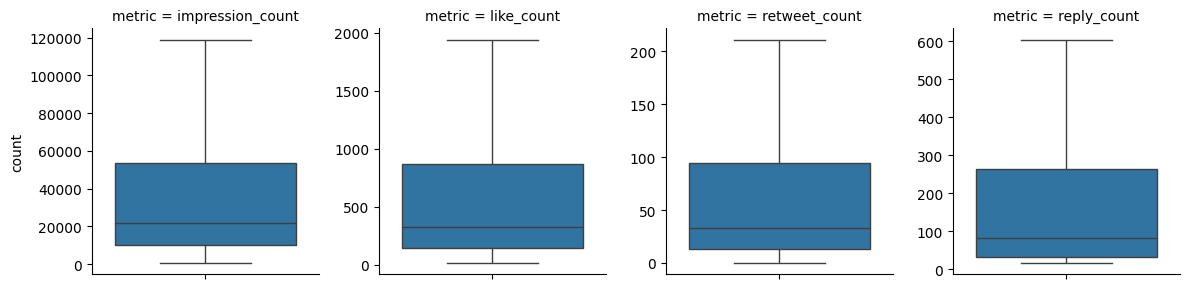

In [9]:
grid = seaborn.FacetGrid(
    data = (
        sampled_posts[METRICS]
        .melt(var_name="metric", value_name="count")
        .pipe(lambda _df: _df.assign(metric=_df["metric"].str.replace("public_metrics.", "")))
    ),
    col="metric",
    sharey=False
)
grid.map_dataframe(seaborn.boxplot, y="count", showfliers=False)

In [11]:
pandas.read_json("../data/raw/twitter.german/mdb_meta.json")

,twitter_username,first_name,last_name,party,role
0,Alice_Weidel,Alice,Weidel,AfD,MdB
1,Beatrix_vStorch,Beatrix,von Storch,AfD,MdB
2,BriHasselmann,Britta,Haßelmann,Bündnis 90/Die Grünen,MdB
3,CarmenWegge,Carmen,Wegge,SPD,MdB
4,DerDanyal,Danyal,Bayal,Bündnis 90/Die Grünen,other:MdL Baden-Württemberg
...,...,...,...,...,...
56,starkwatzinger,Bettina,Stark-Watzinger,FDP,MdB
57,svenlehmann,Sven,Lehmann,Bündnis 90,MdB
58,vonderleyen,Ursula,von der Leyen,CDU,other: europäische Kommission
59,yooHannes,Johannes,Wagner,Bündnis 90/Die Grünen,MdB


In [23]:
classified_data = pandas.json_normalize(cltrier_lib.classify.Pipeline()(list(sampled_posts["text"]), threshold=0.0))
classified_data

,sample,results.topics.arts_&_culture,results.topics.business_&_entrepreneurs,results.topics.celebrity_&_pop_culture,results.topics.diaries_&_daily_life,results.topics.family,results.topics.fashion_&_style,results.topics.film_tv_&_video,results.topics.fitness_&_health,results.topics.food_&_dining,...,results.emotions.trust,results.sentiment.negative,results.sentiment.neutral,results.sentiment.positive,results.irony.non_irony,results.irony.irony,results.offensive.non-offensive,results.offensive.offensive,results.hate.NOT-HATE,results.hate.HATE
0,Verheerende Bilanz der Ampel: 783.000 Tatverdä...,0.049216,0.019987,0.010495,0.034500,0.001857,0.002134,0.026215,0.001907,0.001466,...,0.023664,0.188873,0.799625,0.470375,0.804436,0.250622,0.701602,0.306480,0.962485,0.041475
1,"Statt jegliche Verhandlungen abzulehnen, täte ...",0.026015,0.010681,0.017340,0.033952,0.003003,0.001364,0.021956,0.002919,0.002413,...,0.023060,0.344867,0.781938,0.276057,0.757068,0.334605,0.683155,0.332109,0.894197,0.107060
2,Die Wahrheit ist: Keine echte Fachkraft dieses...,0.138921,0.008744,0.009765,0.104401,0.005710,0.001283,0.018704,0.001544,0.003554,...,0.056527,0.182271,0.806196,0.464130,0.791387,0.259459,0.690443,0.316999,0.947043,0.057651
3,Dass ein Gesundheitssystem das bedingungslose ...,0.080515,0.006388,0.014652,0.132132,0.005177,0.001326,0.011450,0.001943,0.002333,...,0.015827,0.225521,0.782119,0.431825,0.802817,0.290089,0.670879,0.347833,0.954157,0.050746
4,"#Deutschland braucht einen Außenminister, der ...",0.016002,0.008558,0.011285,0.031861,0.002017,0.001197,0.011644,0.002017,0.001156,...,0.038786,0.175190,0.795425,0.495959,0.803558,0.280722,0.700591,0.311810,0.954269,0.050717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,Wie lange wird die Diskussion ums #Tempolimit ...,0.093194,0.003678,0.024760,0.279364,0.003356,0.001580,0.018409,0.001659,0.001563,...,0.021371,0.305283,0.797695,0.307476,0.812919,0.285820,0.673047,0.341922,0.955783,0.052064
911,Wir brauchen keine neuen Autobahnen.,0.147376,0.010832,0.012624,0.288058,0.004063,0.003516,0.021467,0.001636,0.002771,...,0.014189,0.233509,0.798075,0.375907,0.570229,0.569008,0.628341,0.389731,0.963577,0.042817
912,Versteht noch irgendwer die Berliner SPD und #...,0.031506,0.005278,0.013527,0.127938,0.001500,0.001809,0.008064,0.002618,0.001235,...,0.023932,0.209159,0.843025,0.380557,0.759338,0.344348,0.704579,0.316449,0.944549,0.056521
913,#RicardaLang sagt es bei #AnneWill ganz deutli...,0.167137,0.036227,0.063824,0.204411,0.004707,0.007276,0.061939,0.001095,0.001870,...,0.023512,0.170135,0.847885,0.434172,0.609011,0.446005,0.724466,0.285152,0.960222,0.048859


<Axes: xlabel='value', ylabel='variable'>

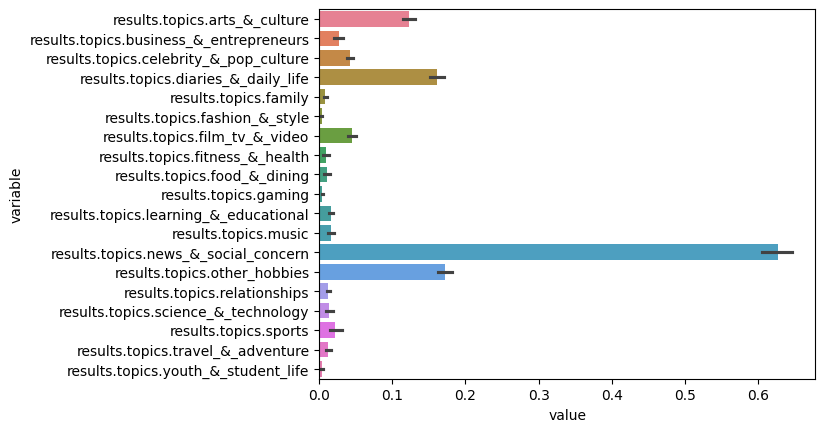

In [24]:
seaborn.barplot(
    classified_data.filter(like=".topics.").melt(),
    x="value", y="variable", hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

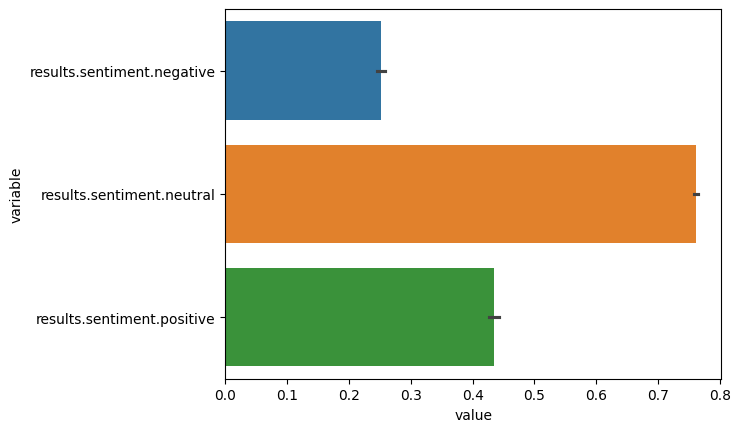

In [25]:
seaborn.barplot(
    classified_data.filter(like=".sentiment.").melt(),
    x="value", y="variable", hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

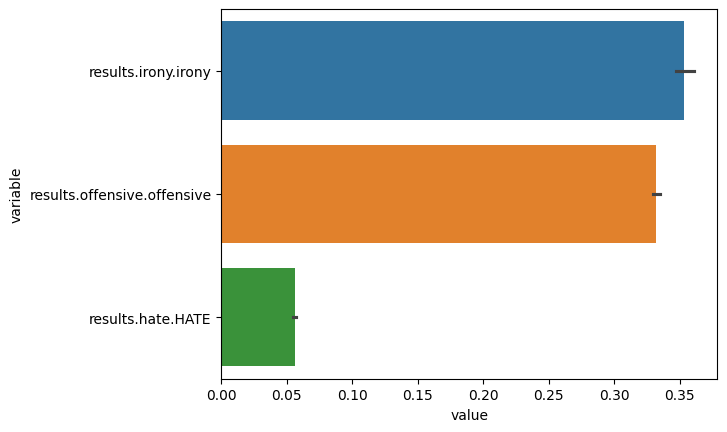

In [26]:
seaborn.barplot(
    classified_data.filter(regex="irony\.irony|offensive\.offensive|hate\.HATE").melt(),
    x="value", y="variable", hue="variable",
)